# First HW Assignment

Many of these exercises use data used in the book "Computer Age Statistical Inference" by Bradley Efron and Trevor Hastie. These datasets can be found on the book webpage https://web.stanford.edu/~hastie/CASI_files/DATA/.

In [263]:
# Installs
# conda install -c conda-forge asteval
# conda install -c conda-forge lmfit

In [10]:
#******************************************************************************#
# Futures
%matplotlib inline
# from __future__ import unicode_literals
# from __future__ import print_function

# Generic/Built-in
import datetime
import argparse

# Other Libs
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from IPython.display import display, Image
from matplotlib.collections import LineCollection
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

# Owned
# from nostalgia_util import log_utils
# from nostalgia_util import settings_util
__authors__   = ["Osamu Katagiri - A01212611@itesm.mx"]
__copyright__ = "None"
__credits__   = ["José Luis Preciado Arreola - jlpreciadoarreola@tec.mx"]
__license__   = "None"
__status__    = "Under Work"
__data__      = "https://web.stanford.edu/~hastie/CASI_files/DATA/"
#******************************************************************************#

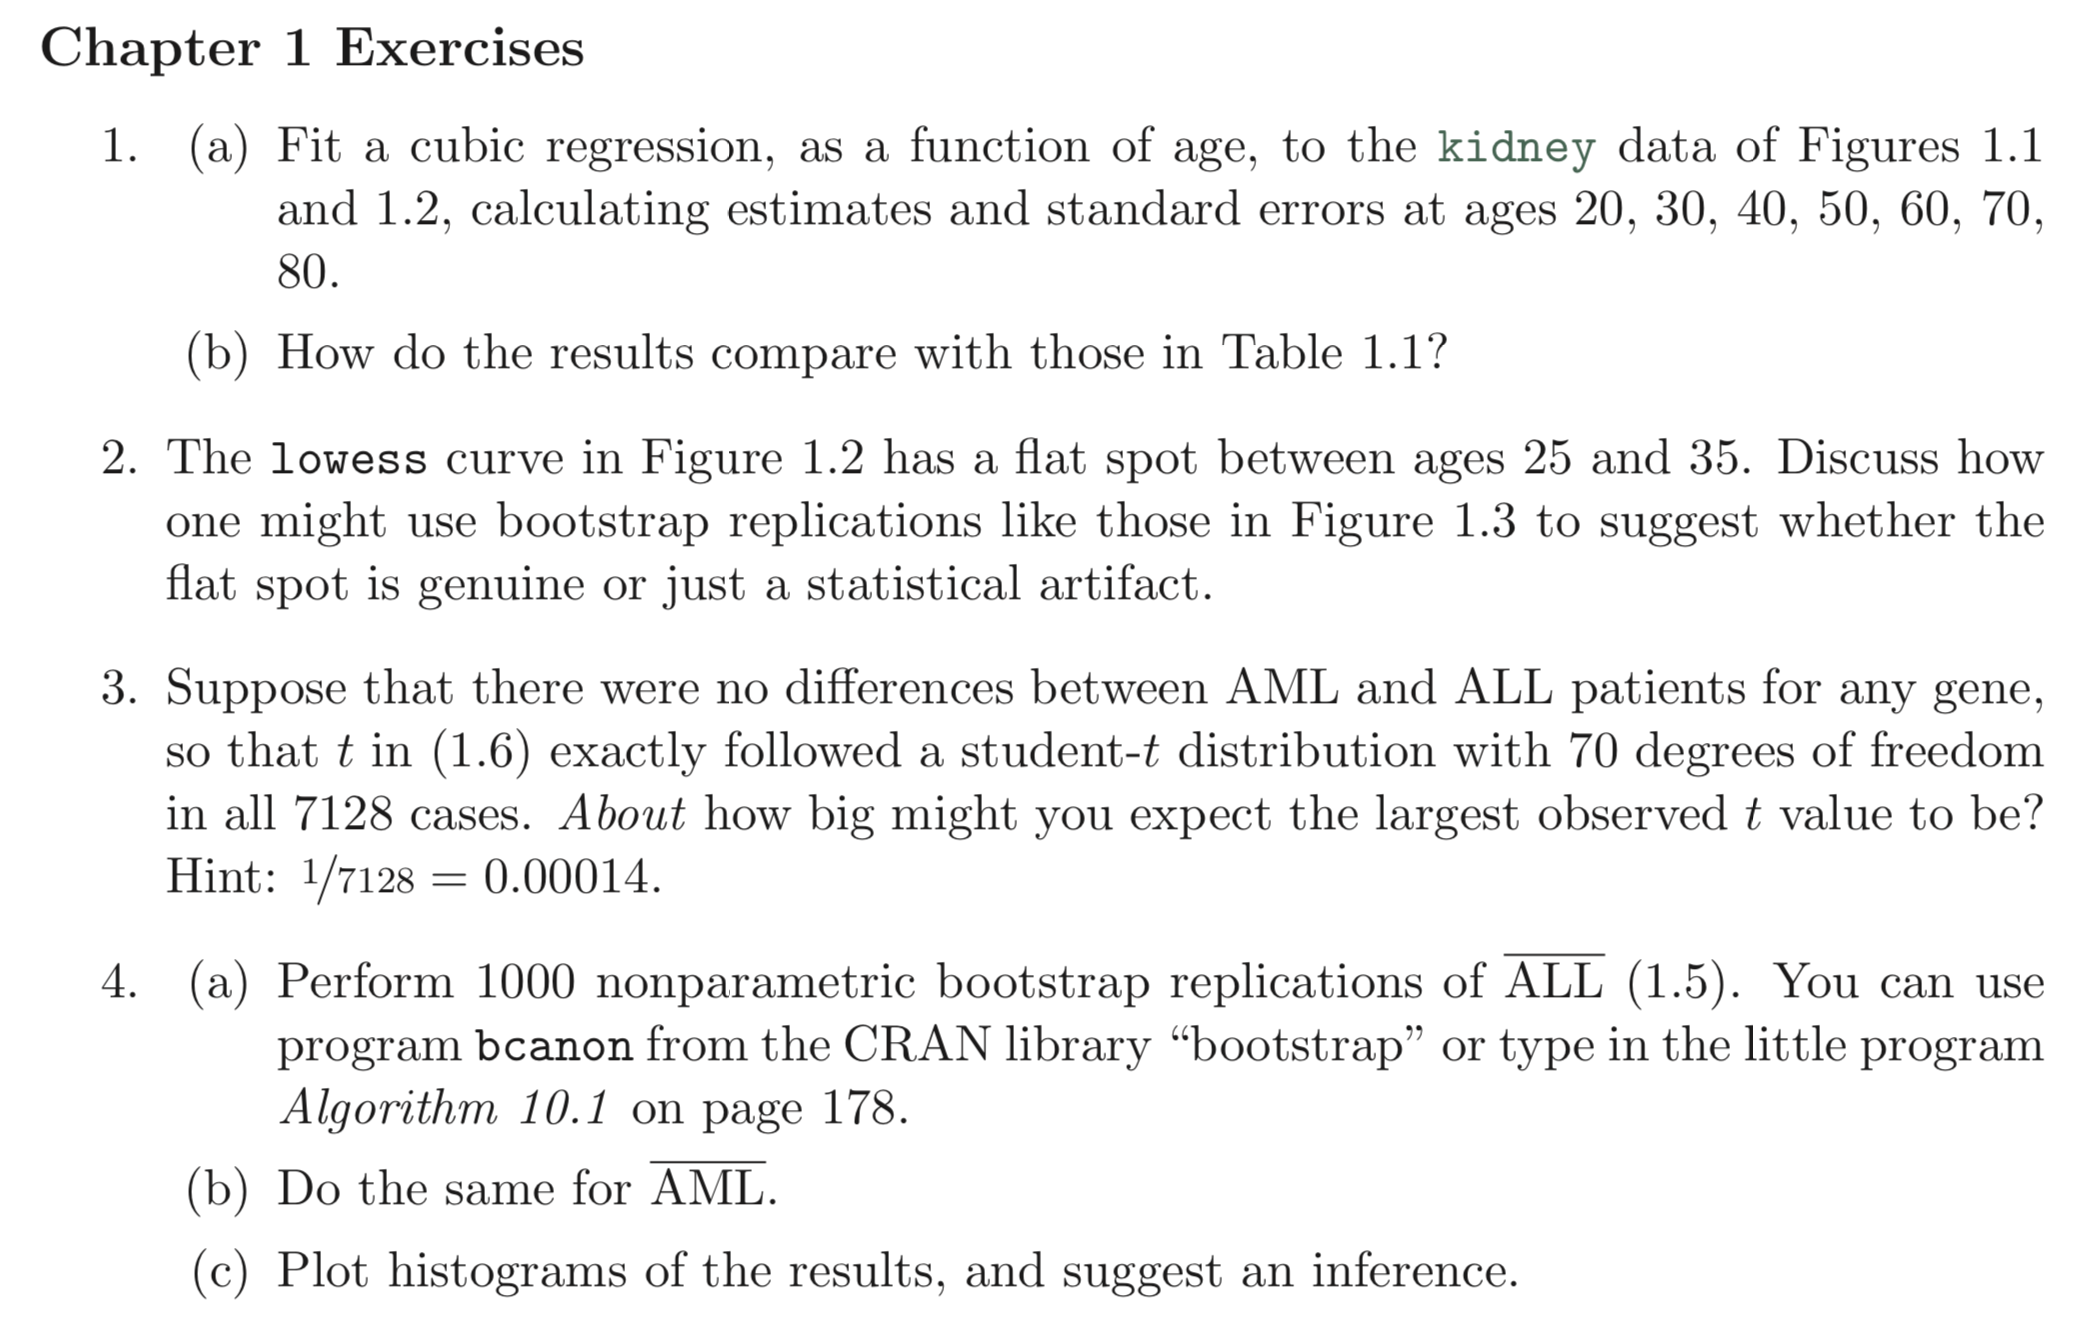

In [11]:
#******************************************************************************#
display(Image(filename='./directions/CH1.png'))

In [12]:
'''Kidney fitness data of Figure 1.1
Measurements on 157 healthy volunteers (potential donors)
These data originated in the nephrology
laboratory of Dr. Brian Myers, Stanford University

age: of volunteer
tot: composite meaure of overall kidney function'''

# load the data
kidney = pd.read_csv(__data__ + "kidney.txt", delimiter=" ")

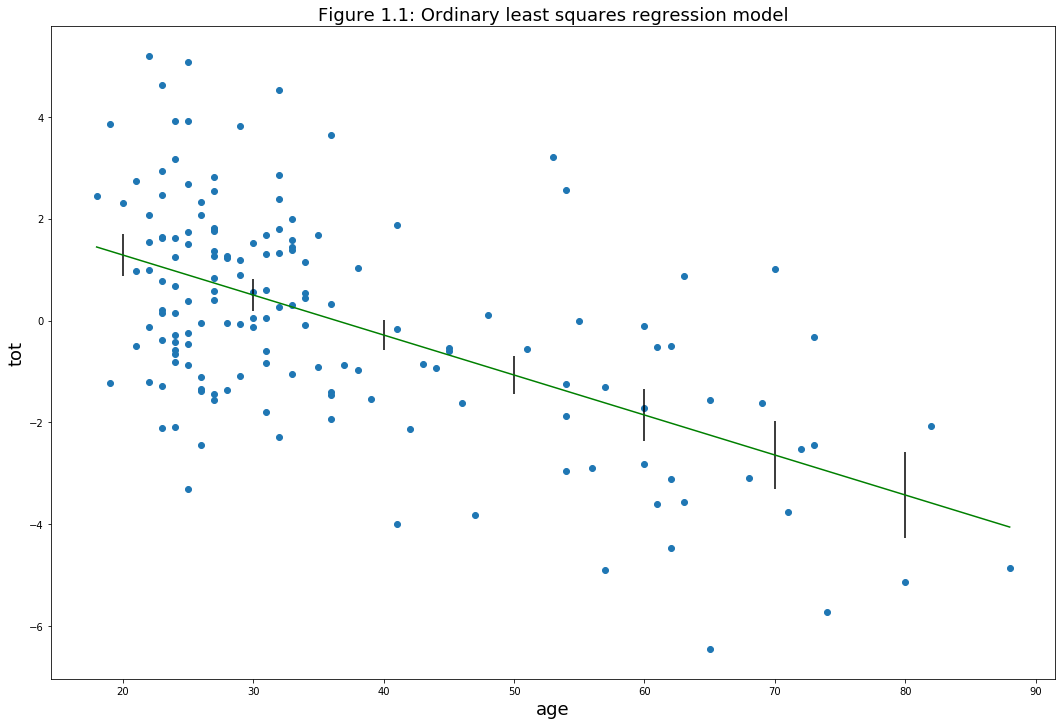

In [86]:
#******************************************************************************#
### Ordinary least squares regression model

# Fit the model
model = smf.ols(formula="tot ~ age", data=kidney)
results = model.fit()

# Create predictions for the regression line
sorted_kidney = kidney.sort_values("age")
OLS_tot_pred = results.predict(sorted_kidney)

# Get predictions and standard error for ages 20, 30, ..., 80
decades = pd.DataFrame({"age": range(20, 90, 10)})
OLS_pred = results.get_prediction(decades)
OLS_pred_info = OLS_pred.summary_frame()
OLS_pred_info.index = decades.age

# Collect info for standard error lines
se_lines = LineCollection(
    [
        [[age, OLS_pred - 2 * se], [age, OLS_pred + 2 * se]]
        for age, OLS_pred, se in zip(OLS_pred_info.index, OLS_pred_info["mean"], OLS_pred_info["mean_se"])
    ],
    color="k"
)

# Figure 1.1
fig, ax = plt.subplots(figsize=(18,12))

ax.scatter(kidney.age, kidney.tot)
ax.plot(sorted_kidney.age, OLS_tot_pred, color="g")
ax.add_collection(se_lines)

ax.set_title("Figure 1.1: Ordinary least squares regression model", size=18)
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

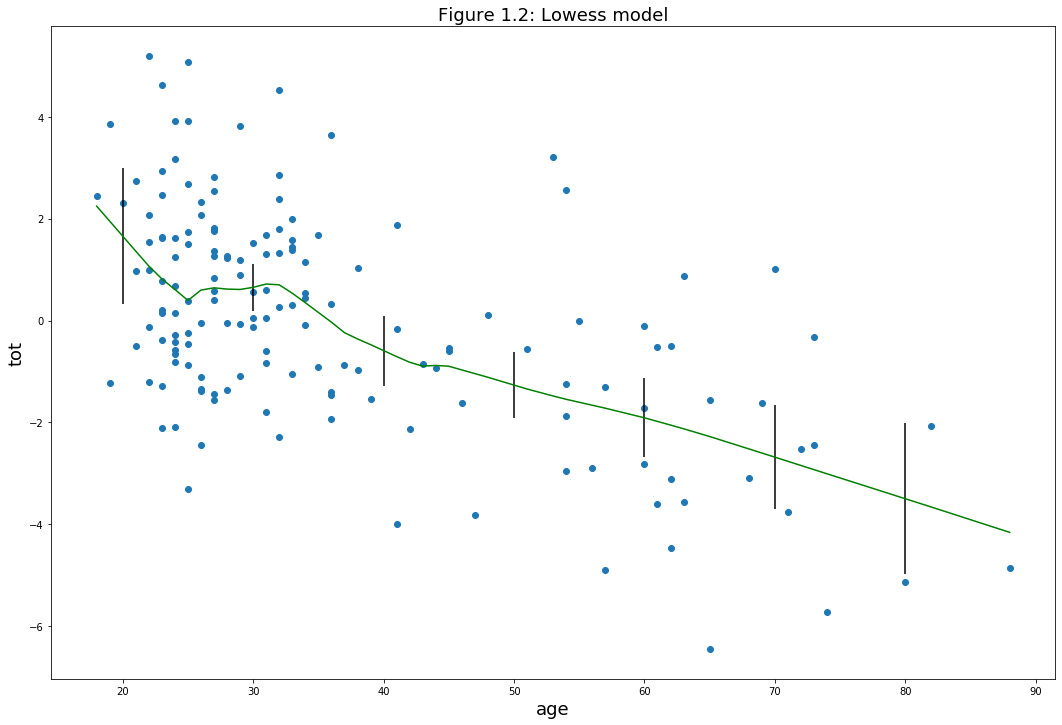

In [101]:
#******************************************************************************#
### Lowess model

low_preds = lowess(kidney.tot, kidney.age, frac=1/3.0)

# Create 250 bootstrap samples of the lowess predictions
low_boots = []
for i in range(250):
    boot_data = kidney.sample(n=kidney.shape[0], replace=True)
    new_preds = lowess(boot_data.tot, boot_data.age, frac=1/3.0)
    low_boots.append(new_preds)
    
# Get bootstrap standard deviation as an estimate of standard error

''' As mentioned above, the return value from lowess is an array of input
x-values (age) and fit lowess values (tot). To get the fit lowess value at a
particular age, we need to interpolate or extrapolate from the ages in the
returned array. We can't assume an age value we're interested in is one of the
input x-values '''

ages = np.array(list(range(20, 90, 10)))

# interpolate lowess predictions for age = 20, 30, ..., 80
dec_preds = np.zeros((7, 250))
for i, pred in enumerate(low_boots):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    dec_preds[:, i] = interpolate(ages)

# get standard deviation for each age
var = np.var(dec_preds, axis=1, ddof=1)
low_sds = np.sqrt(var)

# Collect info for standard error lines
# interpolate/predict from the original lowess predictions
interpolate = interp1d(
    low_preds[:, 0],
    low_preds[:, 1],
    fill_value="extrapolate",
    assume_sorted=True
)

se_lines = LineCollection(
    [
        [[age, interpolate(age) - 2 * se], [age, interpolate(age) + 2 * se]]
        for age, se in zip(ages, low_sds)
    ],
    color="k"
)

# Figure 1.2
fig, ax = plt.subplots(figsize=(18,12))

ax.scatter(kidney.age, kidney.tot)
ax.plot(low_preds[:, 0], low_preds[:, 1], color="g")
ax.add_collection(se_lines)

ax.set_title("Figure 1.2: Lowess model", size=18)
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

## Chapter 1 - Exercice 1.a

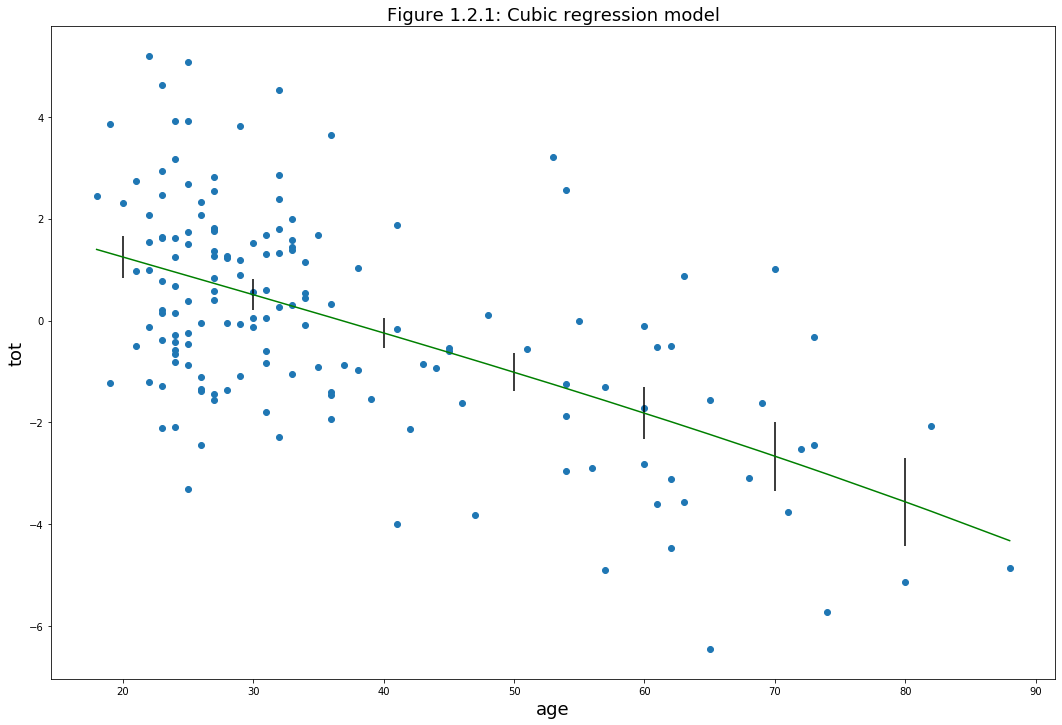

In [97]:
#******************************************************************************#
### Cubic regression model

x = kidney.age
y = kidney.tot
degree = 3
weights = np.polyfit(x, y, degree)
polynomial = np.poly1d(weights)

# Fit the model
cubic_model = smf.ols(formula='tot ~ polynomial(age)', data=kidney)
cubic_model_results = cubic_model.fit()

# Create predictions for the regression line
sorted_kidney = kidney.sort_values("age")
cubic_tot_pred = cubic_model_results.predict(sorted_kidney)

# Get predictions and standard error for ages 20, 30, ..., 80
decades = pd.DataFrame({"age": range(20, 90, 10)})
cubic_pred = cubic_model_results.get_prediction(decades)
cubic_pred_info2 = cubic_pred.summary_frame()
cubic_pred_info2.index = decades.age

# Collect info for standard error lines
cubic_se_lines = LineCollection(
    [
        [[age, cubic_pred - 2 * se], [age, cubic_pred + 2 * se]]
        for age, cubic_pred, se in zip(cubic_pred_info2.index, cubic_pred_info2["mean"], cubic_pred_info2["mean_se"])
    ],
    color="k"
)

# Figure 1.2.1
cubic_fig, cubic_ax = plt.subplots(figsize=(18,12))

cubic_ax.scatter(kidney.age, kidney.tot)
cubic_ax.plot(sorted_kidney.age, cubic_tot_pred, color="g")
cubic_ax.add_collection(cubic_se_lines)

cubic_ax.set_title("Figure 1.2.1: Cubic regression model", size=18)
cubic_ax.set_xlabel("age", size=18)
cubic_ax.set_ylabel("tot", size=18);

## Chapter 1 - Exercice 1.b



Table 1.1:
                                           age
                        -----------------------------------------
                          20    30    40    50    60    70    80
-----------------------------------------------------------------
 1. linear regression   1.29  0.50 -0.28 -1.07 -1.86 -2.64 -3.43
 2. std error           0.21  0.15  0.15  0.19  0.26  0.34  0.42

 3. lowess              1.66  0.65 -0.59 -1.27 -1.91 -2.68 -3.50
 4. boostrap std error  0.68  0.26  0.32  0.30  0.36  0.51  0.76

 5. cubic regression    1.25  0.51 -0.24 -1.01 -1.82 -2.66 -3.56
 6. std error           0.20  0.16  0.15  0.19  0.25  0.34  0.43




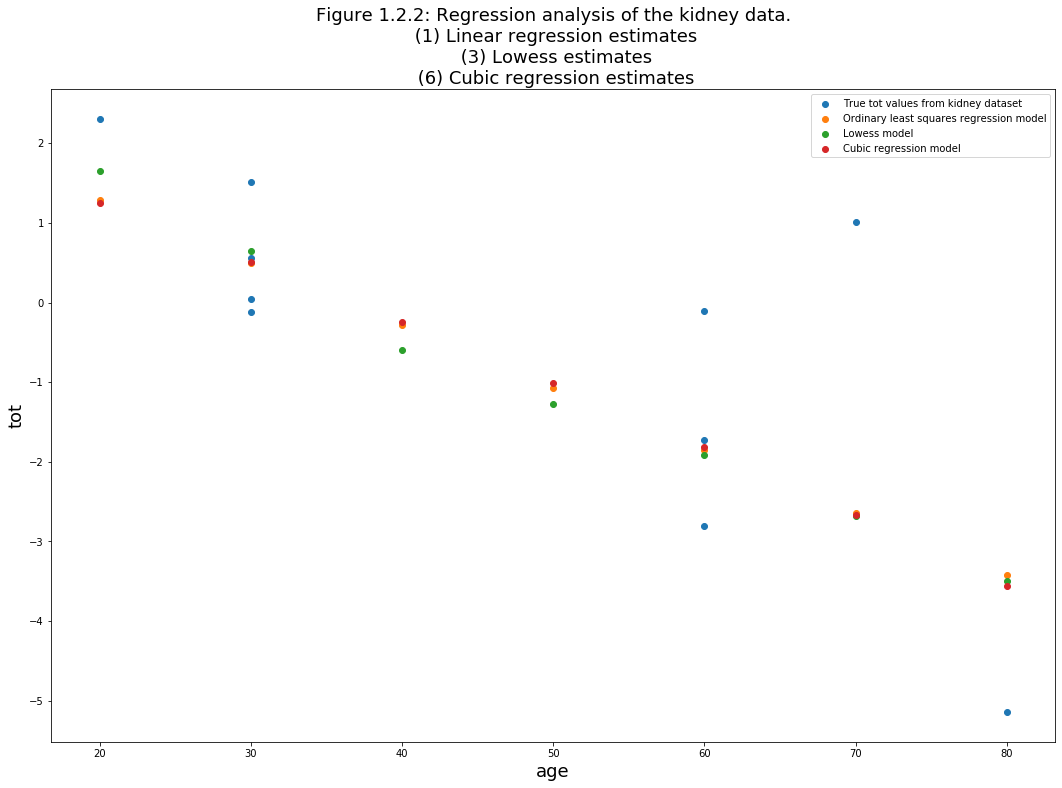

In [96]:
# True kidney tot values at ages 20, 30, ..., 80
#print("age, tot")
true_age = []
true_tot = []
for i in range(kidney.count().age):
    if kidney.age[i] in decades.values:
        #print(str(kidney.age[i]) + ", " + str(kidney.tot[i]))
        true_age.append(kidney.age[i])
        true_tot.append(kidney.tot[i])

# Table 1.1
'''We expect the boostrap standard errors to be close to the book's values, but
not exactly the same, due to randomness and the fact that only 250 bootstrap
samples were used'''

tmplt = " {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f}"
print("\n")
print("Table 1.1:")
print("                                           age")
print("                        -----------------------------------------")
print("                          20    30    40    50    60    70    80")
print("-" * 65)
print(" 1. linear regression " + tmplt.format(*OLS_pred_info["mean"]))
print(" 2. std error         " + tmplt.format(*OLS_pred_info["mean_se"]))
print()
print(" 3. lowess            " + tmplt.format(*interpolate(ages)))
print(" 4. boostrap std error" + tmplt.format(*low_sds))
print()
print(" 5. cubic regression  " + tmplt.format(*cubic_pred_info2["mean"]))
print(" 6. std error         " + tmplt.format(*cubic_pred_info2["mean_se"]))
print("\n")

# Figure 1.2.2
compare_fig, compare_ax = plt.subplots(figsize=(18,12))
compare_ax.scatter(true_age, true_tot)
compare_ax.scatter(decades, pred_info["mean"].values)
compare_ax.scatter(decades, interpolate(ages))
compare_ax.scatter(decades, cubic_pred_info2["mean"].values)

compare_ax.set_title("Figure 1.2.2: Regression analysis of the kidney data.\n (1) Linear regression estimates\n (3) Lowess estimates\n (6) Cubic regression estimates", size=18)
compare_ax.legend(['True tot values from kidney dataset', 'Ordinary least squares regression model','Lowess model','Cubic regression model'])
compare_ax.set_xlabel("age", size=18)
compare_ax.set_ylabel("tot", size=18);

## Chapter 1 - Exercice 2

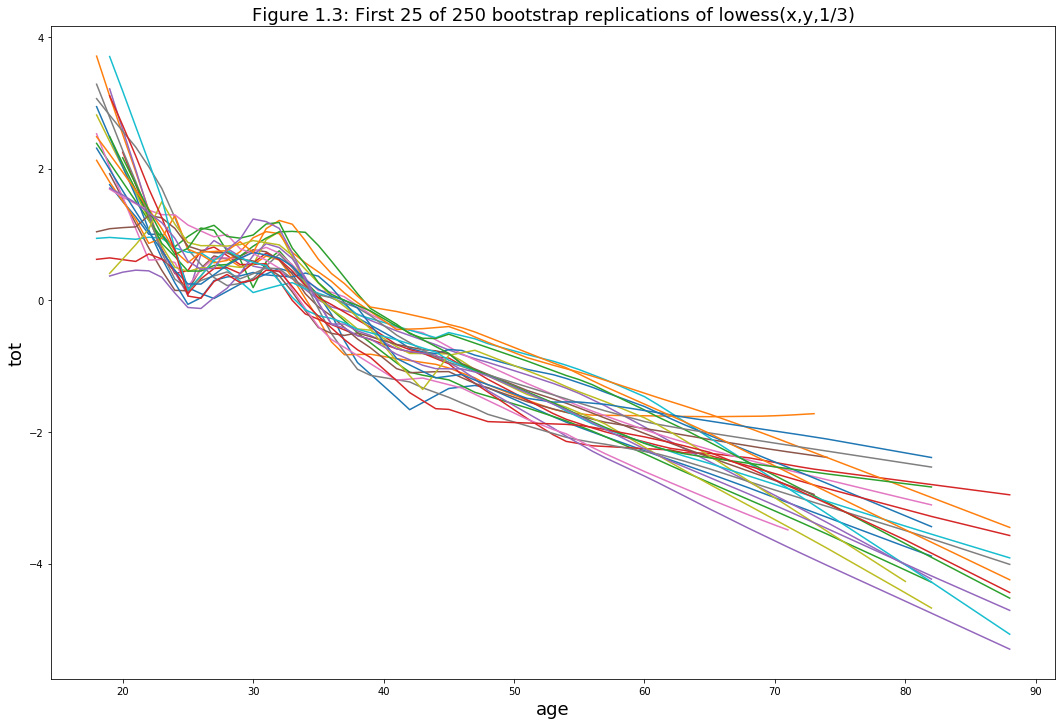

In [102]:
# Figure 1.3
fig, ax = plt.subplots(figsize=(18,12))

for preds in low_boots[:25]:
    ax.plot(preds[:, 0], preds[:, 1])

ax.set_title("Figure 1.3: First 25 of 250 bootstrap replications of lowess(x,y,1/3)", size=18)
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

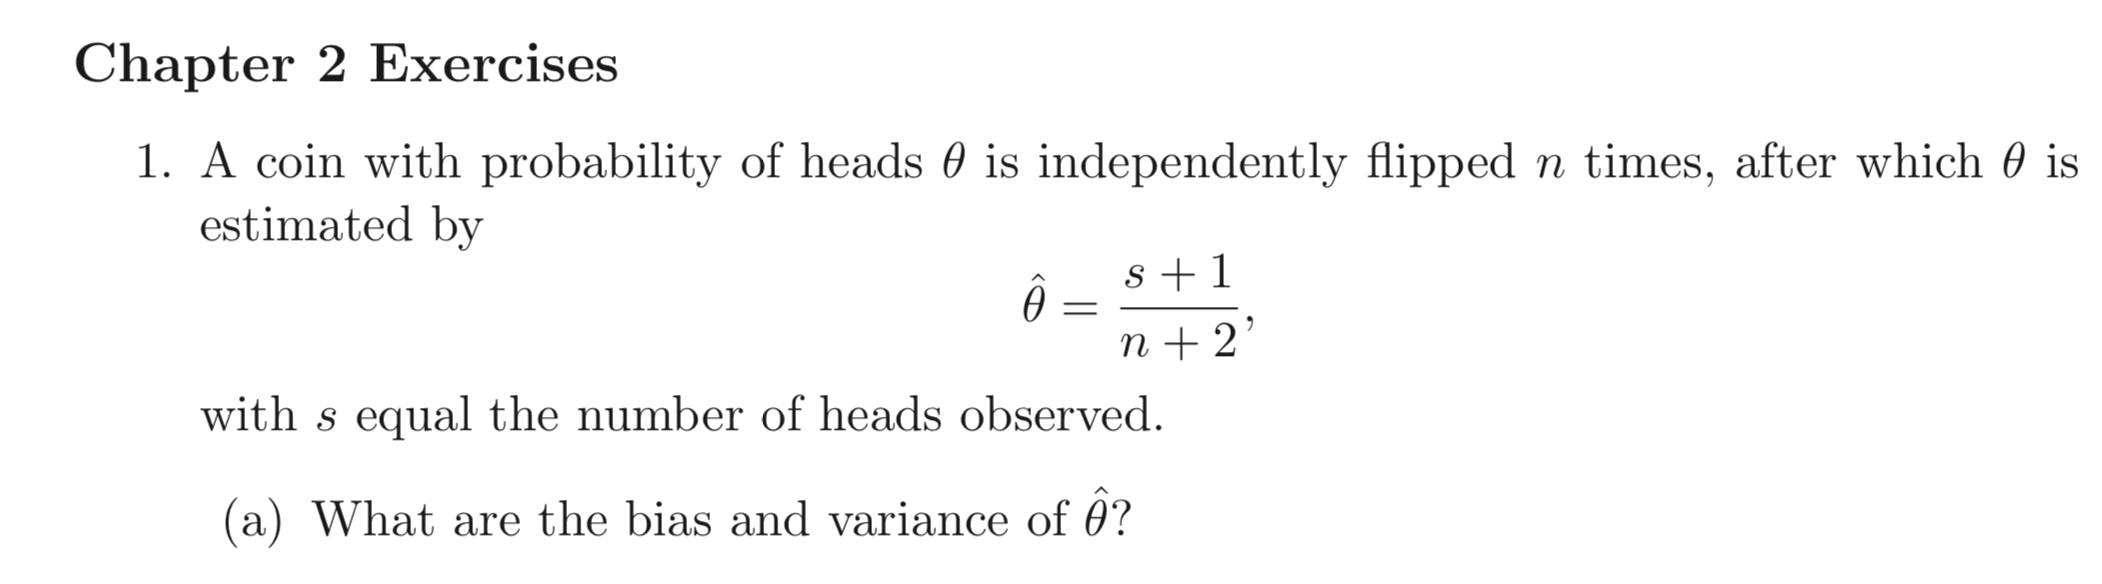

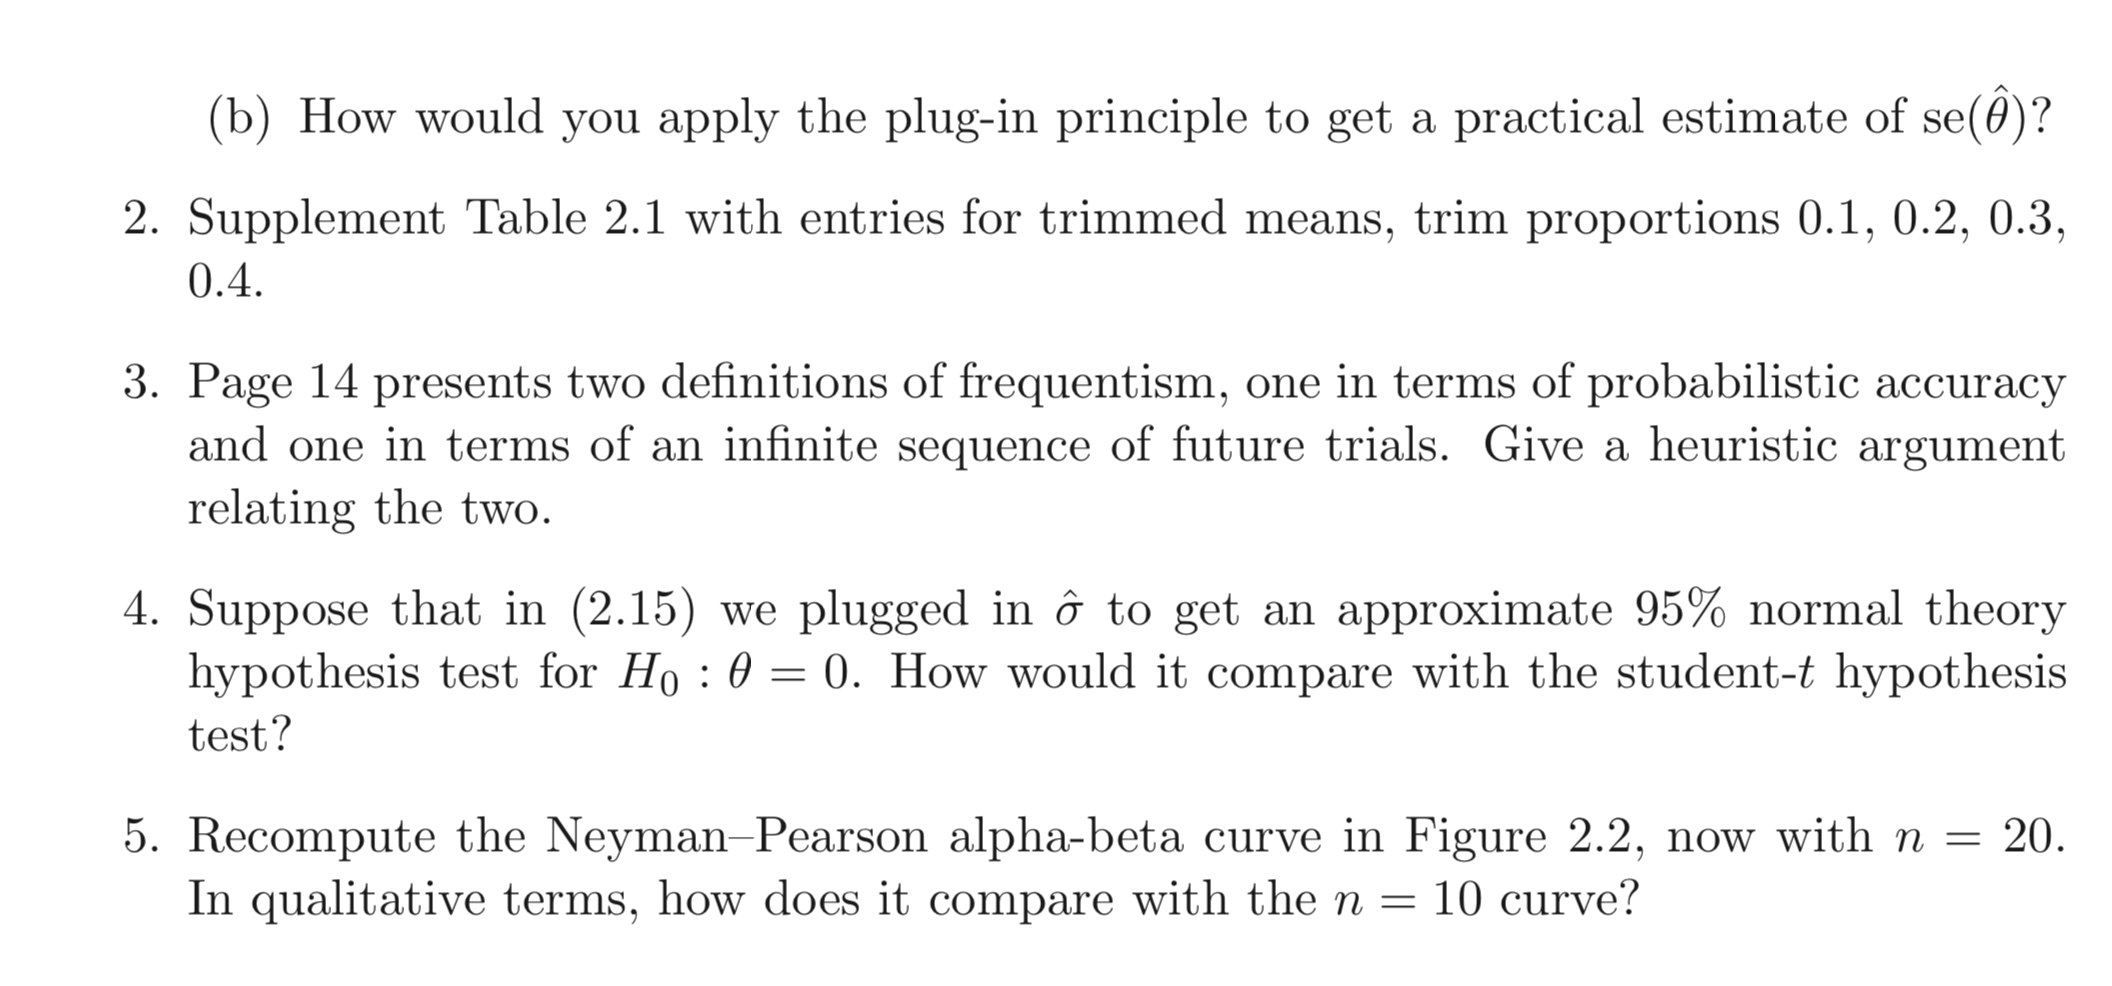

In [17]:
#******************************************************************************#
display(Image(filename='./directions/CH2_1.png'))
display(Image(filename='./directions/CH2_2.png'))